## В данном  блокноте будут рассмотрены различные способы обработки данных, получения эбедингов, среди которых: Bag 0f Words, TF-IDF, Word2Vec, FastText. А также  различные модели: NBC, SVM, RF, CatBoost, RNN и тд



In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.metrics import f1_score


In [63]:
import pandas as pd


df = pd.read_csv("hf://datasets/DmitryKRX/anti_spam_ru/df.csv")
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

X = df_train['text']
y = df_train['is_spam']
X_test = df_test['text']
y_test = df_test['is_spam']

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66119 entries, 0 to 66118
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     66117 non-null  object
 1   is_spam  66119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [67]:
X = [str(x).lower()  for x in X]
X_test = [str(x).lower() for x in X_test]
maxLen = 0
for x in X:
  if len(x.split()) > maxLen:
    maxLen = len(x.split())
print(maxLen)
for x in X_test:
  if len(x.split()) > maxLen:
    maxLen = len(x.split())
print(maxLen)



1186
1380


In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

## Bag of Words


In [71]:
count_vectorizer = CountVectorizer()
X_train_bof = count_vectorizer.fit_transform(X_train)
X_val_bof = count_vectorizer.transform(X_val)
X_test_bof = count_vectorizer.transform(X_test)



При помощи PCA, сократим размерность и откиним компоненты с наименьшей дисперсией, рассмотрев график распределения дисперсии каждой компоненты при начальном значении n_components = 1000

In [73]:
chi2_values, p_values = chi2(X_train_bof, y_train)

In [75]:
features = count_vectorizer.get_feature_names_out()
chi2_df = pd.DataFrame({
    'Feature': features,
    'Chi2': chi2_values,
    'p-value': p_values
})

chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)


In [77]:
total_chi2 = chi2_df['Chi2'].sum()
chi2_df['Chi2_normalized'] = chi2_df['Chi2'] / total_chi2
chi2_df['Chi2_normalized_for_distribution'] = chi2_df['Chi2_normalized'].cumsum()

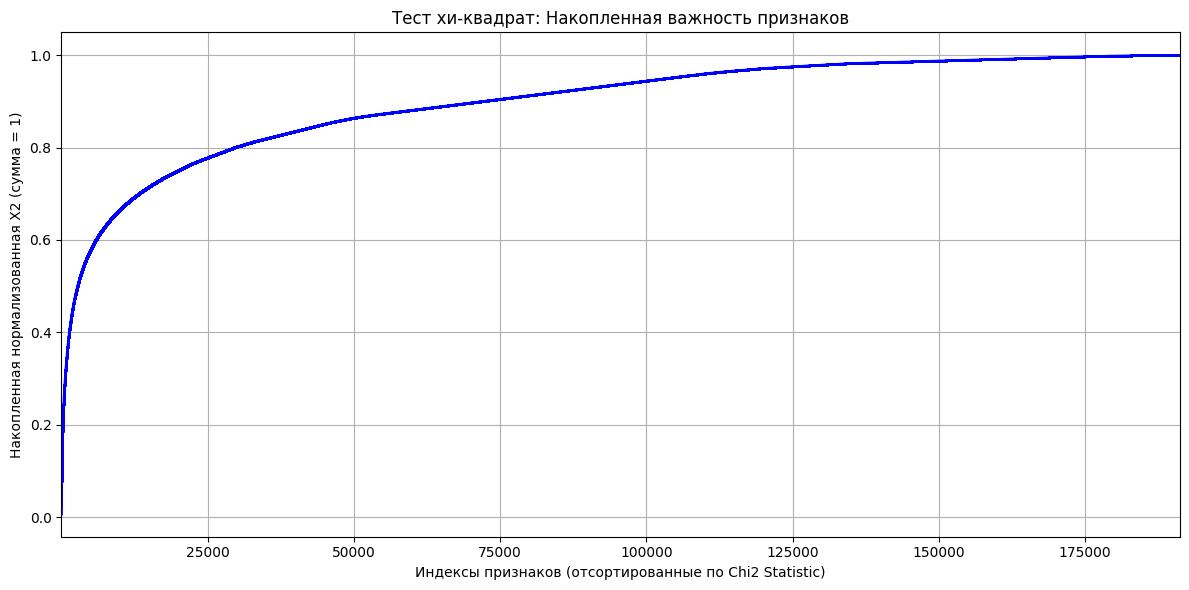

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(chi2_df['Chi2_normalized_for_distribution']) + 1),
        chi2_df['Chi2_normalized_for_distribution'], marker='o', color='blue', markersize=1)

plt.title('Тест хи-квадрат: Накопленная важность признаков')
plt.xlabel('Индексы признаков (отсортированные по Chi2 Statistic)')
plt.ylabel('Накопленная нормализованная X2 (сумма = 1)')
plt.xlim(1, len(chi2_df['Chi2_normalized_for_distribution']))
plt.grid()
plt.tight_layout()
plt.show()


График начинает выходить на асимптоту примерно на 75000

Попробуем другой вид графика, чтобы понять, что самые весомые слова действительно самые важные для классификации

C:\Users\nenad\AppData\Local\Temp\ipykernel_8872\2385409042.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2', y='Feature', data=chi2_df.head(20), palette='viridis')


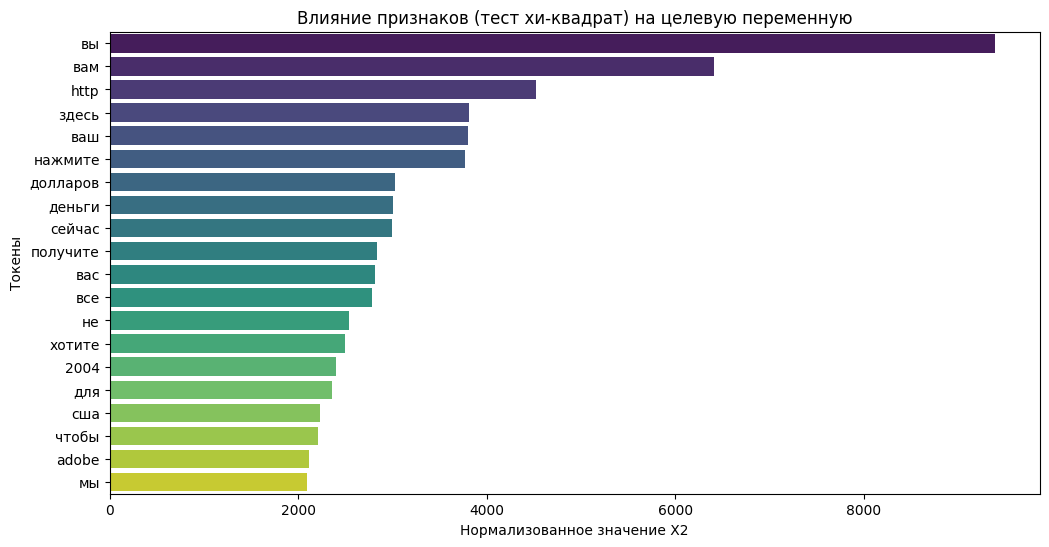

In [81]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2', y='Feature', data=chi2_df.head(20), palette='viridis')
plt.title('Влияние признаков (тест хи-квадрат) на целевую переменную')
plt.xlabel('Нормализованное значение X2')
plt.ylabel('Токены')
plt.show()

Из этого графика интуитивно понятно, что X^2 значения действительно отражают действительность

## TF-IDF

In [83]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train)
X_val_tfidf = tf_idf_vectorizer.transform(X_val)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)

In [ ]:
tokens = tf_idf_vectorizer.get_feature_names_out()
print("Отобранные токены:", tokens)

In [ ]:
print(X_train_tfidf[0])

##### можно пройтись PCA

## FastText unsupervised


In [ ]:
import re

x_train_for_w2v = [re.findall(r'\b\w+\b', x) for x in X_train]

In [ ]:
from gensim.models import Word2Vec
model_word2vec = Word2Vec(x_train_for_w2v,
                 vector_size=32,
                 min_count=5,
                 window=5
                ).wv

In [ ]:
model_word2vec.most_similar("кот")

## LogisticRegrssion с оценкой влияния каждого токена



Попробуем обучить логистическую регрессию и оттуда уже оценить влияние каждого токена на таргет

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_bof, y_train)


In [ ]:
feature_importance = abs(log_reg_model.coef_)
feature_importance = feature_importance[0]
feature_importance

In [ ]:
tokens = count_vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'token': tokens, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df['importance_normalized'] = importance_df['importance'] / importance_df['importance'].sum()
importance_df['cumulative_importance'] = importance_df['importance_normalized'].cumsum()
sorted_tokens = importance_df['token'].tolist()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['cumulative_importance'], marker='o', linestyle='-')
plt.xlabel('Number of Tokens')
plt.ylabel('cumulative_importance')
plt.title('cumulative_importance of Tokens')
plt.grid()
plt.show()

На данном графике отчетливо видно, что брать больше 12500 не имеет смысла (по крайней мере на лог регрессии), так как график выходит на асимптоту


попоробуем несколько 10к признаков, 125000 и 175000 и сравним качество на валидациии и  поймем есть ли смысл брать большей фичей


In [ ]:
from scipy.sparse import csr_matrix

# Индексируем разреженные матрицы
X_train_bof = csr_matrix(X_train_bof)
X_val_bof = csr_matrix(X_val_bof)
X_test_bof = csr_matrix(X_test_bof)

# Получаем числовые индексы для сортировки (если 'sorted_tokens' это список слов, то получаем их индексы)
token_index = {token: idx for idx, token in enumerate(sorted_tokens)}

# Теперь сортируем матрицу по индексу
X_train_bof = X_train_bof[:, [token_index[token] for token in sorted_tokens]]
X_val_bof = X_val_bof[:, [token_index[token] for token in sorted_tokens]]
X_test_bof = X_test_bof[:, [token_index[token] for token in sorted_tokens]]

# Проверка результата
print(X_train_bof.shape)


In [ ]:
num_of_features = {10000:'', # плохое количество фичей
                   75000: '', # оптимальное количество фичей с точки зрения X^2
                   125000:'', # оптимальное количество фичей с точки зрения LogReg
                   191218 :'' # все фичи
                   }
for f in num_of_features.keys():
  log_reg_model.fit(X_train_bof[:,:f], y_train)
  y_pred_val = log_reg_model.predict(X_val_bof[:,:f])
  num_of_features[f] = f1_score(y_val, y_pred_val)
maxY = 0
best_num_of_features = 0
for x, y in num_of_features.items():
  if maxY < y:
    best_num_of_features = x
  print("Количесвто фичей: ", x, "F1: ", y)
# Оценка лучшего результата на тесте
log_reg_model.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = log_reg_model.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print("Лучший результат на тестеа")
print('для ', best_num_of_features, ' фичей f1: ', F1_score)


GridSearch для логистической регрессиии


In [ ]:
from sklearn.metrics import classification_report
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Тип регуляризации
    'C': [0.01, 0.1, 1, 10, 100],  # Инверсия силы регуляризации
    'max_iter': [100, 500, 1000]  # Максимальное количество итераций
}

# Используем GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring='f1',  # Метрика для оптимизации
    cv=5,  # Количество фолдов для кросс-валидации
    verbose=2,
    n_jobs=-1  # Параллелизм
)

# Запуск обучения
grid_search.fit(X_train_bof, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1-скор:", grid_search.best_score_)

# Оценка на валидационной выборке
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val_bof)
print("F1-скор на валидационной выборке:", f1_score(y_val, y_pred_val))

# Подробный отчет
print("Отчет классификации:\n", classification_report(y_val, y_pred_val))

как оказалось, использование всех параметров сильно улучшает метрику и не сильно влияет на время обучение, так что оставляем все параметры

#TF-IDF на логрег

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(max_features = best_num_of_features)
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train)
X_val_tfidf = tf_idf_vectorizer.transform(X_val)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)


In [ ]:
log_reg_model.fit(X_train_tfidf, y_train)
y_pred_test = log_reg_model.predict(X_test_tfidf)
f1_score(y_test, y_pred_test)

# word2vec на логрег


In [ ]:
def text_df_to_w2v(df):
  df_for_w2v = []
  for x in df:
    curr_sentence = re.findall(r'\b\w+\b', x)
    curr_vec = np.zeros(32)
    for word in curr_sentence:
      if word in model_word2vec:
        curr_vec += model_word2vec[word]
    df_for_w2v.append(curr_vec)
  df_for_w2v = pd.DataFrame( df_for_w2v)
  return df_for_w2v
X_train_for_w2v = text_df_to_w2v(X_train)

In [ ]:
X_train_for_w2v.head()

In [ ]:

log_reg_model.fit(X_train_for_w2v, y_train)

In [ ]:
y_pred_test = log_reg_model.predict(text_df_to_w2v(X_test))
f1_score(y_test, y_pred_test)

0.5652686465654047

Как и ожидалось простое запихивании суммы векторов w2v предложения в лог рег не даст даст нужных результатов


# MNBC на CountVectorizer

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
MNBC_clf = MultinomialNB()

In [ ]:
num_of_features = {10000:'', # плохое количество фичей
                   75000: '', # оптимальное количество фичей с точки зрения X^2
                   125000:'', # оптимальное количество фичей с точки зрения LogReg
                   191218 :'' # все фичи
                   }
for f in num_of_features.keys():
  MNBC_clf.fit(X_train_bof[:,:f], y_train)
  y_pred_val = MNBC_clf.predict(X_val_bof[:,:f])
  num_of_features[f] = f1_score(y_val, y_pred_val)
maxY = 0
best_num_of_features = 0
for x, y in num_of_features.items():
  if maxY < y:
    maxY = y
    best_num_of_features = x
  print("Количесвто фичей: ", x, "F1: ", y)
# Оценка лучшего результата на тесте
MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = MNBC_clf.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print("Лучший результат на тестеа")
print('для ', best_num_of_features, ' фичей f1: ', F1_score)


In [ ]:
alphas = np.arange(0.1, 2, 0.15)
best_alpha = 0
best_f1 = 0
for a in alphas:
  MNBC_clf = MultinomialNB(alpha = a)
  MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
  y_pred_val = MNBC_clf.predict(X_val_bof[:,:best_num_of_features],)
  F1 = f1_score(y_val, y_pred_val)
  print('alpha: ', a, 'f1: ', F1)
  if F1 > best_f1:
    best_f1 = F1
    best_alpha = a

print('=============')
MNBC_clf = MultinomialNB(alpha = best_alpha)
MNBC_clf.fit(X_train_bof[:,:best_num_of_features], y_train)
y_pred_test = MNBC_clf.predict(X_test_bof[:,:best_num_of_features])
F1_score = f1_score(y_test, y_pred_test)
print('Итог: ', F1_score, "для alpha = ", best_alpha)

# MNBC на TFIDF

In [ ]:
# Зададим параметры для перебора
param_grid = {
    'max_features': [10000, 75000, 125000, 191218],  # Число признаков
    'min_df': [1, 2, 5],  # Минимальная частота слов в документах
    'max_df': [0.7, 0.85, 1.0],  # Максимальная доля документов, в которых слово встречается
    'sublinear_tf': [True],  # Используем sublinear_tf
    'ngram_range': [(1, 1), (1, 2)]  # Биграммы и униграммы
}

# Инициализация TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Преобразуем данные в виде пайплайна
X_train_raw = X_train  # Оригинальные тексты
pipeline = GridSearchCV(
    estimator=tfidf_vectorizer,
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # Кросс-валидация
    verbose=2,
    n_jobs=-1
)

# Подбор гиперпараметров
pipeline.fit(X_train_raw, y_train)
best_params = pipeline.best_params_

# Выводим лучшие параметры
print("Лучшие параметры TF-IDF:", best_params)


In [ ]:
# Используем лучшие параметры для преобразования данных
tfidf_vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df'],
    sublinear_tf=best_params['sublinear_tf'],
    ngram_range=best_params['ngram_range']
)

# Преобразуем данные
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение MNBC
mnbc_clf = MultinomialNB()
mnbc_clf.fit(X_train_tfidf, y_train)

# Оценка модели на тесте
y_pred_test = mnbc_clf.predict(X_test_tfidf)
f1 = f1_score(y_test, y_pred_test)
print("F1-Score на тесте:", f1)


модель генеративная (в том смысле, что работает с вероятностями), поэтому веса в tf-idf ей только мешают

# SVM на CountVectorizer

In [ ]:
from scipy.sparse import vstack

In [ ]:
X_grid_bow = vstack([X_train_bof[:,:best_num_of_features], X_val_bof[:,:best_num_of_features]])
y_grid = np.concatenate([y_train, y_val])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000, 3000, 5000]

}
linear_svc = LinearSVC(random_state=42, max_iter=10000)
grid_search_bow = GridSearchCV(linear_svc, param_grid, scoring='f1', cv=3)
grid_search_bow.fit(X_grid_bow, y_grid)




In [ ]:
# Оценка модели на тест выборке
best_svc_bow = grid_search_bow.best_estimator_
y_pred_bow = best_svc_bow.predict(X_test_bof[:,:best_num_of_features])
f1_bow = f1_score(y_test, y_pred_bow)

print(f"Лучший F1-score на тестовой выборке (Bag of Words): {f1_bow}")
print(f"Лучший параметр C (Bag of Words): {grid_search_bow.best_params_['C']}")

In [ ]:
print(grid_search_bow.best_params_)

# SVM на TF-IDF


In [ ]:
X_grid_tfidf = vstack([X_train_tfidf, X_val_tfidf])

In [ ]:
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Подбор гиперпараметра C с помощью GridSearchCV для TF-IDF
grid_search_tfidf = GridSearchCV(linear_svc, param_grid, scoring='f1', cv=3)
grid_search_tfidf.fit(X_grid_tfidf, y_grid)


In [ ]:
best_svc_tfidf = grid_search_tfidf.best_estimator_
y_pred_tfidf = best_svc_tfidf.predict(X_test_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"Лучший F1-score на валидационной выборке (TF-IDF): {f1_tfidf}")
print(f"Лучший параметр C (TF-IDF): {grid_search_tfidf.best_params_['C']}")

# CatBoost на CountVectorizer


In [ ]:
!pip install catboost

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [ ]:
# Гиперпараметры для подбора на BoW представлении
param_grid_bow = {
    'depth': [4, 6],
    'iterations': [200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}
CB = CatBoostClassifier(loss_function='Logloss', eval_metric='F1', verbose=0)

In [ ]:

# GridSearch для BoW
grid_search_bow = GridSearchCV(estimator=CB, param_grid=param_grid_bow, scoring='f1', cv=3, n_jobs=-1)
grid_search_bow.fit(X_grid_bow, y_grid)

# Лучшая модель и гиперпараметры для BoW
best_CB = grid_search_bow.best_estimator_
print("Best parameters for BoW:", grid_search_bow.best_params_)
print("Best F1 Score for BoW:", grid_search_bow.best_score_)

# Оценка на валидационной выборке
y_pred_bow = best_CB.predict(X_test_bof[:,:best_num_of_features])
f1_bow = f1_score(y_test, y_pred_bow)
print(f'F1 Score on Test Set (BoW): {f1_bow}')


# CatBoost на TF-IDF


In [ ]:

CB = CatBoostClassifier(loss_function='Logloss', eval_metric='F1', verbose=0)

# Гиперпараметры для подбора на BoW представлении
param_grid_bow = {
    'depth': [4, 6, 8],
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}



In [ ]:

# GridSearch для BoW
grid_search_bow = GridSearchCV(estimator=CB, param_grid=param_grid_bow, scoring='f1', cv=3, n_jobs=-1)
grid_search_bow.fit(X_grid_tfidf, y_grid)

# Лучшая модель и гиперпараметры для BoW
best_CB = grid_search_bow.best_estimator_
print("Best parameters for BoW:", grid_search_bow.best_params_)
print("Best F1 Score for BoW:", grid_search_bow.best_score_)

# Оценка на валидационной выборке
y_pred_bow = best_CB.predict(X_test_bof)
f1_bow = f1_score(y_test, y_pred_bow)
print(f'F1 Score on Test Set (BoW): {f1_bow}')


# RNN на W2V
